# 浦发银行量化交易回测模型

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 加载数据

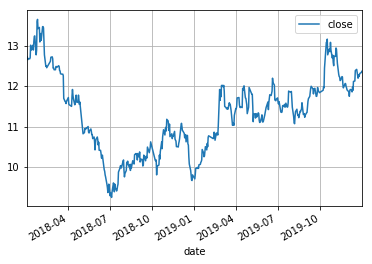

In [28]:
data = pd.read_csv('pfyh.csv', header=None, names=['date', 'open', 'high', 'low', 'close', 'ma5', 'ma10', 'volume'])
data['date'] = pd.to_datetime(data['date'])
data.plot(x='date', y='close', grid=True)

In [29]:
data.describe()

open        high         low       close         ma5        ma10  \
count  487.000000  487.000000  487.000000  487.000000  487.000000  487.000000   
mean    11.302238   11.406242   11.198768   11.296715   11.297713   11.299458   
std      0.964352    0.981289    0.954958    0.968787    0.960244    0.952560   
min      9.260000    9.350000    9.170000    9.240000    9.312000    9.402000   
25%     10.565000   10.660000   10.465000   10.555000   10.555000   10.549500   
50%     11.390000   11.460000   11.300000   11.370000   11.396000   11.382000   
75%     11.950000   12.040000   11.840000   11.920000   11.899000   11.881000   
max     13.650000   14.000000   13.360000   13.660000   13.450000   13.383000   

             volume  
count  4.870000e+02  
mean   3.742897e+05  
std    3.517131e+05  
min    8.995716e+04  
25%    1.980381e+05  
50%    2.732542e+05  
75%    4.008432e+05  
max    3.796536e+06

In [55]:
# 使用tushare获取历史股票数据，进行回测验证
import tushare as ts
data = ts.get_hist_data('600519')
data = data.reset_index().sort_values(by='date')
data = data[['date', 'open', 'high', 'low', 'close', 'ma5', 'ma10', 'ma20',  'volume']]
data['date'] = pd.to_datetime(data['date'])
data.head()

date   open    high     low   close      ma5     ma10     ma20  \
606 2017-12-19  663.0  672.44  661.00  667.30  667.300  667.300  667.300   
605 2017-12-20  669.9  686.86  664.03  684.98  676.140  676.140  676.140   
604 2017-12-21  683.0  687.42  675.50  681.90  678.060  678.060  678.060   
603 2017-12-22  680.0  685.90  677.01  682.98  679.290  679.290  679.290   
602 2017-12-25  686.0  696.30  683.72  688.10  681.052  681.052  681.052   

       volume  
606  44072.21  
605  63601.31  
604  46680.38  
603  28317.01  
602  36214.28

In [56]:
# 申明一个函数，传入一个日期参数，假设该日期为当前日期，根据已知数据，返回策略输出：
# -1 (建议卖出)  1(建议买入)  0(建议持有)

def profit(mdate):
    # 基于均线理论，判断金叉死叉，从而返回相应策略结果
    mask = data['date'] <= mdate 
    if mask.sum() < 2:
        return 0
    today_data = data[mask].iloc[-1]
    yesterday_data = data[mask].iloc[-2]
    # 昨天的5日均线与10日均线
    yma5, yma10 = yesterday_data['ma10'], yesterday_data['ma20']
    # 今天的5日均线与10日均线
    tma5, tma10 = today_data['ma10'], today_data['ma20']
    # 判断金叉 死叉
    if (yma10 >= yma5) and (tma10 <= tma5):  # 金叉
        return 1
    if (yma10 <= yma5) and (tma10 >= tma5):  # 死叉
        return -1
    return 0

profit(pd.to_datetime('20180123'))

0

In [57]:
# 判断每一天是涨还是跌
profits = data['date'].apply(profit)
profits.value_counts()

 0    569
 1     24
-1     14
Name: date, dtype: int64

## 编写回测模型，使用已知数据，验证投资策略


In [58]:
# 定义资产
assets = 1000000  # 现金
stocks = 0        # 持有股票数量
payment_price = 0 # 当前交易价格
status = 0        # 当前交易状态：1：已买入    -1：已卖出

for index, profit in profits.items():
    payment_price = data['close'][index]
    if (profit == 1) and (status != 1):
        # 如果建议买入，则修改相关变量，模拟买入操作
        stocks = int(assets / payment_price)
        assets = assets - stocks * payment_price
        status = 1
        print("买入：dates:{}, payment price:{}, assets:{}, stocks:{}".format(data['date'][index], payment_price, assets, stocks))
    if (profit == -1) and (status != -1):
        # 如果建议卖出，则修改相关变量，模拟卖出操作
        assets = assets + stocks * payment_price
        stocks = 0
        status = -1
        print("卖出：dates:{}, payment price:{}, assets:{}, stocks:{}".format(data['date'][index], payment_price, assets, stocks))
    

买入：dates:2017-12-20 00:00:00, payment price:684.98, assets:614.1799999999348, stocks:1459
卖出：dates:2018-01-30 00:00:00, payment price:742.02, assets:1083221.3599999999, stocks:0
买入：dates:2018-03-02 00:00:00, payment price:736.1, assets:418.2599999997765, stocks:1471
卖出：dates:2018-03-15 00:00:00, payment price:746.5, assets:1098519.7599999998, stocks:0
买入：dates:2018-03-21 00:00:00, payment price:742.2, assets:63.75999999977648, stocks:1480
卖出：dates:2018-03-29 00:00:00, payment price:689.5, assets:1020523.7599999998, stocks:0
买入：dates:2018-05-09 00:00:00, payment price:701.99, assets:532.2899999998044, stocks:1453
卖出：dates:2018-06-27 00:00:00, payment price:722.55, assets:1050397.4399999997, stocks:0
买入：dates:2018-07-19 00:00:00, payment price:741.45, assets:504.23999999975786, stocks:1416
卖出：dates:2018-08-02 00:00:00, payment price:695.23, assets:984949.9199999998, stocks:0
买入：dates:2018-09-03 00:00:00, payment price:666.21, assets:291.5399999998044, stocks:1478
卖出：dates:2018-09-11 00:0

In [59]:
data.head()

date   open    high     low   close      ma5     ma10     ma20  \
606 2017-12-19  663.0  672.44  661.00  667.30  667.300  667.300  667.300   
605 2017-12-20  669.9  686.86  664.03  684.98  676.140  676.140  676.140   
604 2017-12-21  683.0  687.42  675.50  681.90  678.060  678.060  678.060   
603 2017-12-22  680.0  685.90  677.01  682.98  679.290  679.290  679.290   
602 2017-12-25  686.0  696.30  683.72  688.10  681.052  681.052  681.052   

       volume  
606  44072.21  
605  63601.31  
604  46680.38  
603  28317.01  
602  36214.28

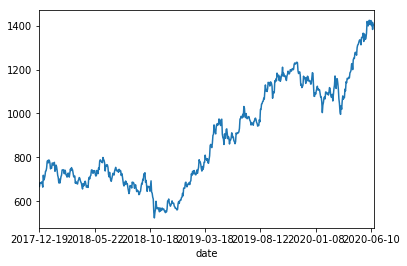

In [60]:
import tushare as ts
data = ts.get_hist_data('600519')
data = data.sort_index()
data['close'].plot()